In [18]:
!pip install torchmetrics

In [19]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchmetrics import Accuracy
import matplotlib.pyplot as plt


In [20]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_dataset = datasets.FashionMNIST(root='./data',
                                      train=True, # Train dataset
                                      download=True,
                                      transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data',
                                     train=False, # Test dataset
                                     download=True,
                                     transform=transforms.ToTensor())

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

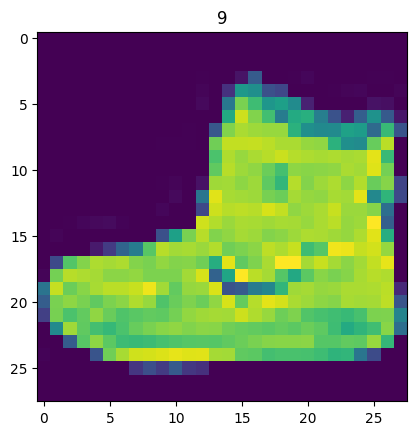

In [21]:
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)


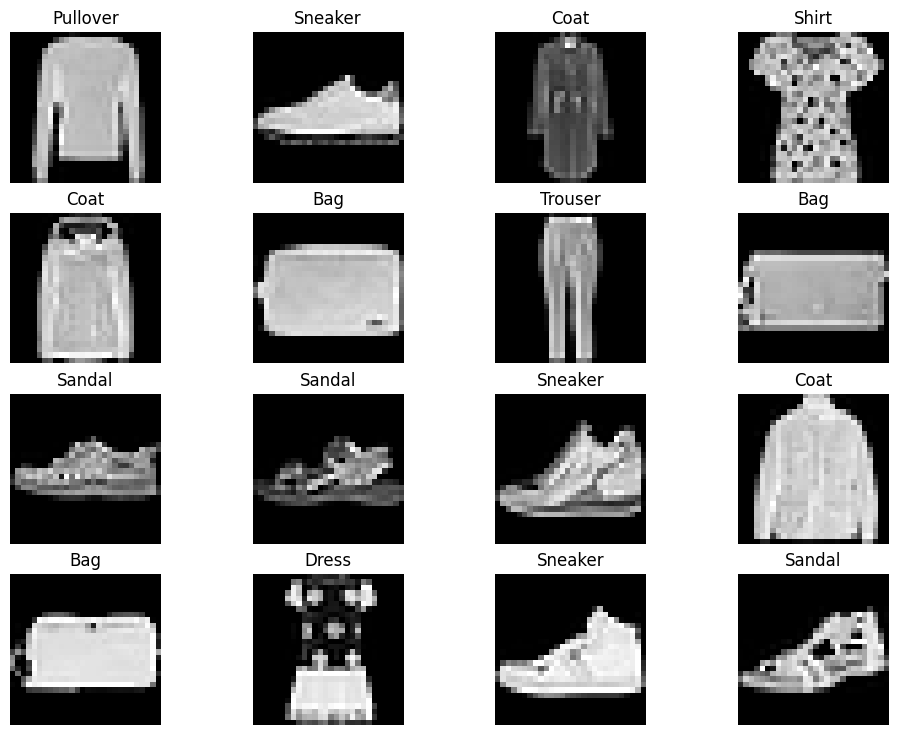

In [22]:

figure = plt.figure(figsize=(12, 9))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [23]:
training_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  drop_last=True)
testing_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=32,
                                                 shuffle=False,
                                                 drop_last=True)

print("DataLoaders created!")
print(f"Training batches: {len(training_dataloader)}")
print(f"Test batches: {len(testing_dataloader)}")


DataLoaders created!
Training batches: 1875
Test batches: 312


In [24]:
# Let's see what our batches look like
for images, labels in training_dataloader:
    print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
    print(f"Labels shape: {labels.shape}") # [batch_size]
    print(f"First batch - Images: {images.shape}, Labels: {labels.shape}")
    break  # Just look at the first batch


Batch shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])
First batch - Images: torch.Size([32, 1, 28, 28]), Labels: torch.Size([32])


In [25]:
class FashionFlattenClassifier(nn.Module):
    def __init__(self, output_shape):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(), # 28×28 pixels = 784 input features
            nn.Linear(in_features=784,
                      out_features= output_shape)
        )

    def forward(self, x):
        # Flatten the image from [batch_size, 1, 28, 28] to [batch_size, 784]
        return self.classifier(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

# Instantiate our model
model = FashionFlattenClassifier(output_shape = 10).to(device)
print(model)


Using cpu
FashionFlattenClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)


In [27]:
!pip install torchmetrics

In [28]:
EPOCHS = 10
total_epoch_count = []
train_losses, test_losses = [], []
train_accs, test_accs = [], []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS + 1):
  model.train() # training mode
  train_loss, train_acc = 0, 0
  for batch_idx, (X, y) in enumerate(training_dataloader):
    X_train, y_train = X.to(device), y.to(device)
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    y_preds = logits.argmax(dim=1)

    # Backward + Optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc += accuracy_mc(y_preds, y_train)
    train_loss += loss

  # Testing
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in testing_dataloader:
      X_test, y_test = X.to(device), y.to(device)
      logits = model(X_test)
      t_loss = loss_fn(logits, y_test)
      y_preds = logits.argmax(dim=1)

      test_loss += t_loss
      test_acc += accuracy_mc(y_preds, y_test)
  avg_training_loss = train_loss / len(training_dataloader)
  avg_testing_loss = test_loss / len(testing_dataloader)
  avg_training_acc = train_acc / len(training_dataloader)
  avg_testing_acc = test_acc / len(testing_dataloader)

  # Print progress
  if epoch % 1 == 0 or epoch == 0 or epoch == EPOCHS:
      print(f"Epoch: {epoch} | "
            f"train_loss: {avg_training_loss:.3f} | "
            f"train_acc: {avg_training_acc:.3f} | "
            f"test_loss: {avg_testing_loss:.3f} | "
            f"test_acc: {avg_testing_acc:.3f} | ")

      total_epoch_count.append(epoch)
      train_losses.append(avg_training_loss.detach().numpy())
      test_losses.append(avg_testing_loss.detach().numpy())
      train_accs.append(avg_training_acc)
      test_accs.append(avg_testing_acc)



Epoch: 0 | train_loss: 1.471 | train_acc: 0.603 | test_loss: 1.110 | test_acc: 0.666 | 
Epoch: 1 | train_loss: 0.984 | train_acc: 0.694 | test_loss: 0.917 | test_acc: 0.704 | 
Epoch: 2 | train_loss: 0.854 | train_acc: 0.730 | test_loss: 0.831 | test_acc: 0.729 | 
Epoch: 3 | train_loss: 0.786 | train_acc: 0.752 | test_loss: 0.779 | test_acc: 0.747 | 
Epoch: 4 | train_loss: 0.742 | train_acc: 0.766 | test_loss: 0.743 | test_acc: 0.757 | 
Epoch: 5 | train_loss: 0.710 | train_acc: 0.776 | test_loss: 0.716 | test_acc: 0.765 | 
Epoch: 6 | train_loss: 0.685 | train_acc: 0.784 | test_loss: 0.694 | test_acc: 0.773 | 
Epoch: 7 | train_loss: 0.665 | train_acc: 0.790 | test_loss: 0.677 | test_acc: 0.779 | 
Epoch: 8 | train_loss: 0.649 | train_acc: 0.795 | test_loss: 0.662 | test_acc: 0.783 | 
Epoch: 9 | train_loss: 0.635 | train_acc: 0.798 | test_loss: 0.649 | test_acc: 0.787 | 
Epoch: 10 | train_loss: 0.623 | train_acc: 0.803 | test_loss: 0.639 | test_acc: 0.789 | 


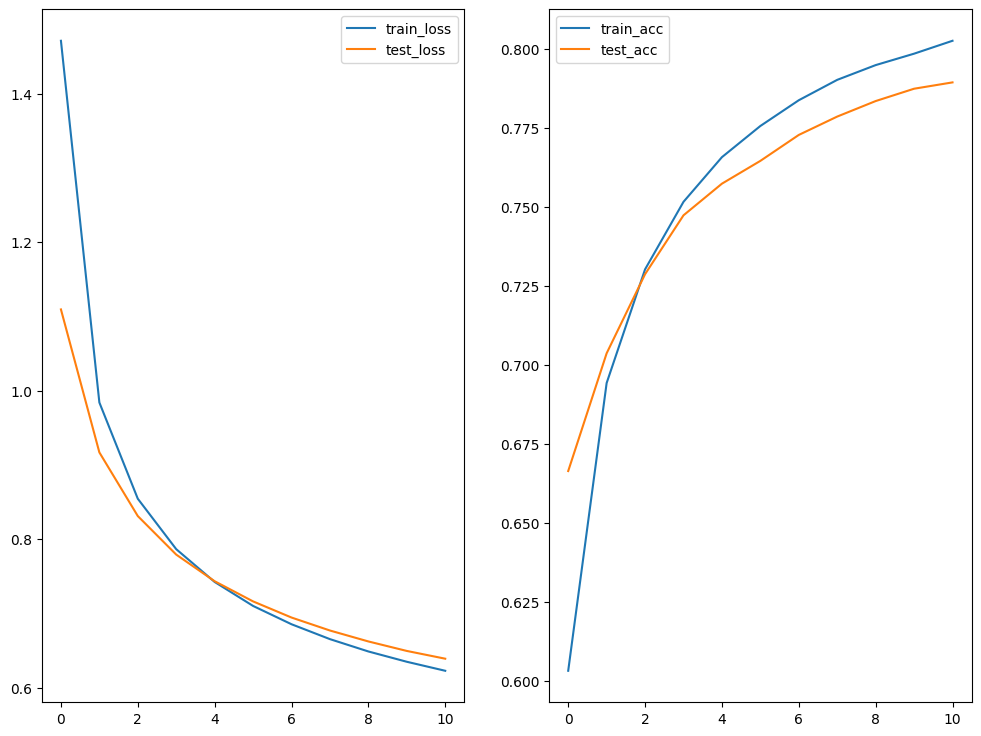

In [29]:
figure = plt.figure(figsize=(12, 9))
plt.subplot(1,2,1)
plt.plot(total_epoch_count, train_losses, label="train_loss")
plt.plot(total_epoch_count, test_losses, label="test_loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(total_epoch_count, train_accs, label="train_acc")
plt.plot(total_epoch_count, test_accs, label="test_acc")
plt.legend()
plt.show()